# Лабораторная работа 3.1 Анализ и визуализация временного ряда бизнес-показателей


**Цель работы.** Освоить ключевые методы анализа временных рядов на языке Python для решения практических бизнес-задач, таких как прогнозирование, выявление трендов и сезонности в экономических показателях.

## Введение. Почему временные ряды важны для бизнеса?

Временные ряды — это наборы данных, где каждая точка привязана к определенному моменту времени. Для бизнес-информатики это один из самых ценных активов, позволяющий:

- **Прогнозировать спрос.** Оптимизировать запасы и логистику.
- **Анализировать финансовые рынки.** Предсказывать цены акций и курсы валют.
- **Оценивать эффективность маркетинга.** Отслеживать влияние рекламных кампаний на продажи во времени.
- **Планировать ресурсы.** Прогнозировать нагрузку на серверы или количество обращений в колл-центр.

В этой работе мы научимся извлекать из временных данных ценные инсайты, строить и оценивать прогнозные модели.

### Основные характеристики временных рядов

- **Тренд (Trend).** Долгосрочное направление движения ряда (рост, падение, стагнация).
- **Сезонность (Seasonality).** Периодические, повторяющиеся колебания (например, рост продаж перед Новым годом).
- **Циклы (Cycles).** Долгосрочные волнообразные колебания, не связанные с фиксированным периодом, как у сезонности (например, экономические циклы).
- **Шум (Noise/Residual).** Случайные, непрогнозируемые колебания.
- **Стационарность.** Свойство ряда, при котором его статистические характеристики (среднее, дисперсия) не меняются со временем. Большинство моделей требуют, чтобы ряд был стационарным.

## Часть 1. Подготовка к анализу

Перед началом работы установим и импортируем все необходимые библиотеки.

In [1]:
# Установка библиотек (если требуется)
!pip install pandas numpy matplotlib seaborn statsmodels scikit-learn -q

# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Настройки для визуализаций
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

### Работа с датами и временем в Pandas

Правильная работа с временными метками — основа анализа временных рядов. Pandas предоставляет мощный инструментарий для этого.

**Задание 1. Создание DataFrame и преобразование в формат даты**

Создайте DataFrame на основе предоставленных данных о продажах. Преобразуйте столбец `'Дата'` в специальный формат `datetime` с помощью `pd.to_datetime()` и выведите типы данных DataFrame с помощью `.info()`.

In [2]:
data = {'Дата': ['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01'],
        'Продажи': [1000, 1200, 1300, 1100, 1400]}

# Ваш код здесь
# 1. Создайте DataFrame 'df' из словаря 'data'
df = pd.DataFrame(data)
# 2. Преобразуйте столбец 'Дата'
df['Дата'] = pd.to_datetime(df['Дата'], errors='coerce')
# 3. Выведите информацию о DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Дата     5 non-null      datetime64[ns]
 1   Продажи  5 non-null      int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 212.0 bytes


**Задание 2. Установка временного индекса**

Для удобной работы с временными рядами столбец с датами часто устанавливают в качестве индекса DataFrame. Используйте метод `.set_index()` для установки столбца `'Дата'` в качестве индекса.

In [3]:
# Ваш код здесь
# Установите 'Дата' в качестве индекса для df
# Задание 2
df = df.set_index('Дата')
display(df)

,Продажи
Дата,
2023-01-01,1000
2023-02-01,1200
2023-03-01,1300
2023-04-01,1100
2023-05-01,1400


**Задание 3. Фильтрация данных по дате**

Используя временной индекс, выберите данные о продажах за период с марта по апрель 2023 года включительно.

In [4]:
# Ваш код здесь
df_mar_apr = df.loc['2023-03':'2023-04']
display(df_mar_apr)

,Продажи
Дата,
2023-03-01,1300
2023-04-01,1100


### Обработка пропущенных значений

Реальные бизнес-данные часто содержат пропуски. Их корректная обработка — критически важный шаг.

**Задание 4. Обнаружение пропущенных значений**

Создайте новый DataFrame `df_missing` с пропущенным значением. Используйте `.isnull().sum()` для подсчета количества пропусков в каждом столбце.

In [5]:
data_missing = {'Дата': ['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01'],
                  'Продажи': [1000, None, 1300, 1100, 1400]}
df_missing = pd.DataFrame(data_missing)
df_missing['Дата'] = pd.to_datetime(df_missing['Дата'])
df_missing.set_index('Дата', inplace=True)

# Ваш код здесь
# Посчитайте пропущенные значения
null_counts = df_missing.isnull().sum()

display(null_counts.to_frame('nu_count'))

,nu_count
Продажи,1


**Задание 5. Заполнение пропусков средним значением**

Заполните пропущенное значение в столбце `'Продажи'` средним значением этого же столбца. Это более robustный подход, чем заполнение нулем. Не забудьте переприсвоить результат.

In [6]:
# Ваш код здесь
# 1. Рассчитайте среднее по столбцу 'Продажи'
mean_val = df_missing['Продажи'].mean(skipna=True)
# 2. Заполните пропуски с помощью .fillna()
df_missing_mean = df_missing.copy()
df_missing_mean['Продажи'] = df_missing_mean['Продажи'].fillna(mean_val)

display(pd.DataFrame({'mean': [mean_val]}))
print()
display(df_missing_mean)

,mean
0,1200.0


,Продажи
Дата,
2023-01-01,1000.0
2023-02-01,1200.0
2023-03-01,1300.0
2023-04-01,1100.0
2023-05-01,1400.0


**Задание 6. Заполнение пропусков методом интерполяции**

Интерполяция заполняет пропуски, вычисляя промежуточные значения между двумя известными точками. Это часто дает более реалистичный результат. Примените метод `.interpolate()` к `df_missing`.

In [7]:
# Ваш код здесь
df_missing_int = df_missing.copy()
df_missing_int['Продажи'] = df_missing_int['Продажи'].interpolate(method='time')

display(df_missing_int)
print()
display(df_missing_int.isnull().sum().to_frame('count_after'))

,Продажи
Дата,
2023-01-01,1000.000000
2023-02-01,1157.627119
2023-03-01,1300.000000
2023-04-01,1100.000000
2023-05-01,1400.000000


,count_after
Продажи,0


## Часть 2. Исследовательский анализ временных рядов (EDA)

На этом этапе мы будем использовать реальный набор данных о ежемесячном производстве бензина в США. Наша цель — визуализировать данные и выявить их основные компоненты.

**Задание 7. Загрузка и подготовка данных**

Загрузите данные по ссылке. Убедитесь, что столбец с датой преобразован в `datetime` и установлен в качестве индекса. Выведите первые 5 строк.

In [8]:
# Ваш код здесь
gas_url = "https://raw.githubusercontent.com/BosenkoTM/Python_for_scientists/refs/heads/main/data/US_gasoline_production.csv"

# Загрузите данные, используя parse_dates=['date'] и index_col='date'
gas = pd.read_csv(gas_url, parse_dates=['date'], index_col='date')
gas = gas.sort_index()

display(gas.head())

,value
date,
1991-02-03,6.621
1991-02-10,6.433
1991-02-17,6.582
1991-02-24,7.224
1991-03-03,6.875


**Задание 8. Визуализация временного ряда**

Постройте линейный график для столбца `'value'`, чтобы визуально оценить данные. Добавьте заголовок и подписи осей.

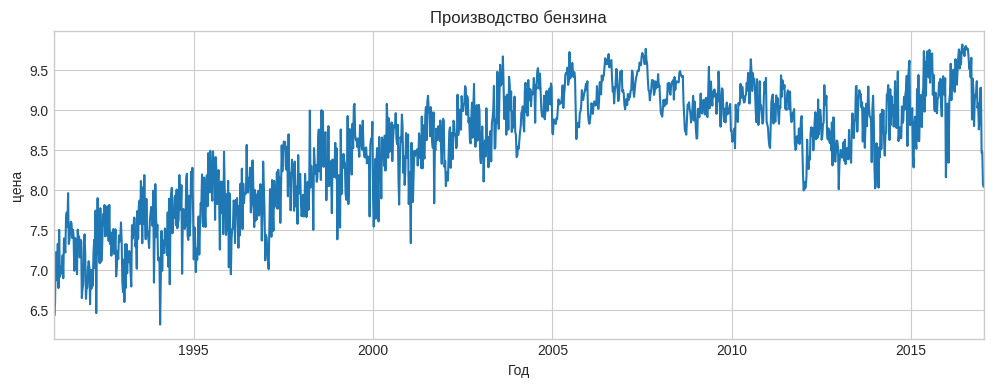

In [9]:
# Ваш код здесь
ax = gas['value'].plot(figsize=(12,4))
ax.set_title('Производство бензина')
ax.set_xlabel('Год'); ax.set_ylabel('цена')
plt.show()

**Задание 9. Ресэмплинг для агрегации данных**

Исходные данные имеют еженедельную частоту, что делает график 'шумным'. Преобразуйте ряд в ежемесячный (`'M'`), агрегируя значения с помощью среднего (`.mean()`). Сохраните результат в `gas_monthly` и постройте график.

/tmp/ipython-input-2852890388.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  gas_monthly = gas.resample('M').mean()


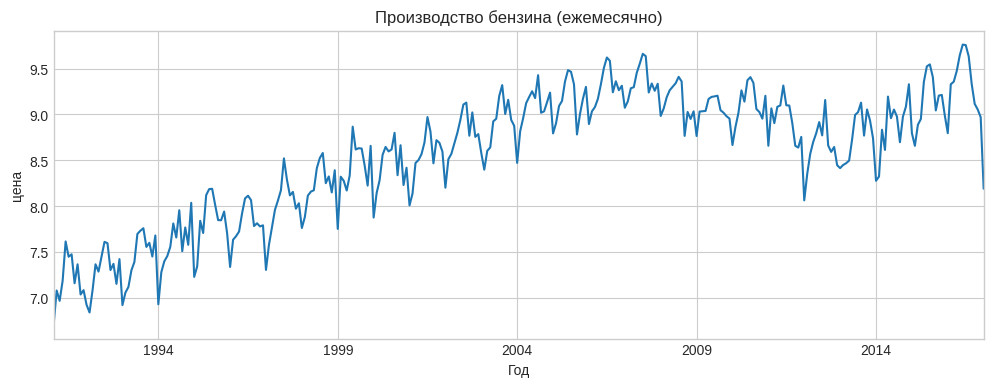

In [10]:
# Ваш код здесь
# 1. Выполните ресэмплинг
gas_monthly = gas.resample('M').mean()
# 2. Постройте график для gas_monthly['value']
ax = gas_monthly['value'].plot(figsize=(12,4))
ax.set_title('Производство бензина (ежемесячно)')
ax.set_xlabel('Год'); ax.set_ylabel('цена')
plt.show()

**Задание 10. Сглаживание с помощью скользящего среднего**

Чтобы лучше увидеть долгосрочный тренд, примените скользящее среднее. Создайте новый столбец `'rolling_mean_12'` в `gas_monthly`, рассчитав среднее за 12 месяцев с помощью `.rolling(window=12).mean()`. Постройте на одном графике исходный ряд и сглаженный.

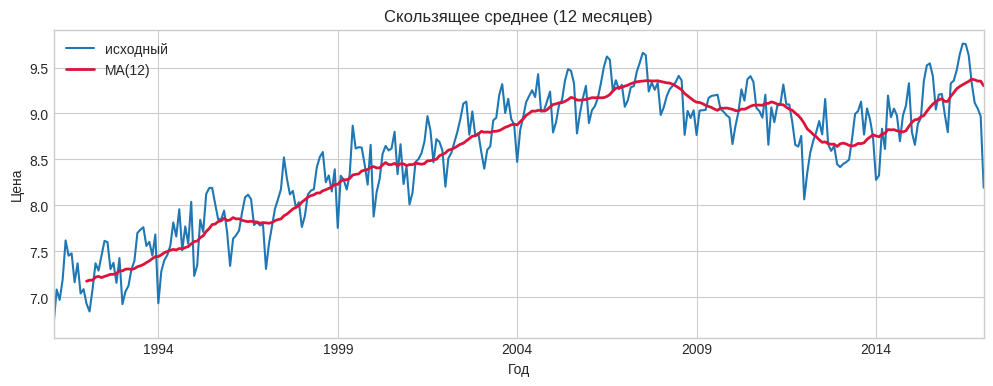

In [11]:
# Ваш код здесь
# 1. Рассчитайте скользящее среднее
gas_monthly['rolling_mean_12'] = gas_monthly['value'].rolling(window=12).mean()
# 2. Постройте оба графика
plt.figure(figsize=(12,4))
gas_monthly['value'].plot(label='исходный')
gas_monthly['rolling_mean_12'].plot(label='MA(12)', color='crimson', linewidth=2)
plt.title('Скользящее среднее (12 месяцев)')
plt.xlabel('Год'); plt.ylabel('Цена'); plt.legend()
plt.show()

**Задание 11. Декомпозиция временного ряда**

Используйте `seasonal_decompose` из `statsmodels`, чтобы разложить ежемесячный ряд `gas_monthly['value']` на тренд, сезонность и остаток. Визуализируйте результат с помощью метода `.plot()`.

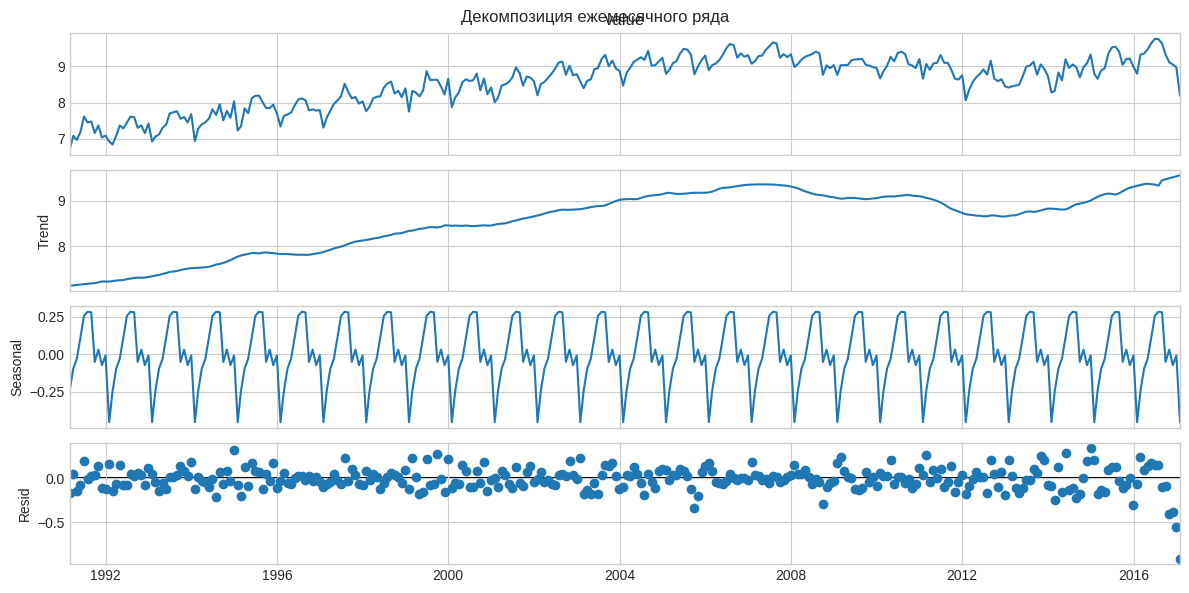

In [12]:
# Ваш код здесь
# 1. Выполните декомпозицию
dec = seasonal_decompose(gas_monthly['value'].dropna(), model='additive', period=12, extrapolate_trend='freq')
# 2. Постройте график
dec.plot()
plt.suptitle('Декомпозиция ежемесячного ряда')
plt.show()

## Часть 3. Стационарность и корреляционный анализ

**Задание 12. Проверка на стационарность**

Проведите расширенный тест Дики-Фуллера (`adfuller`) для ряда `gas_monthly['value']`. Проанализируйте p-значение и сделайте вывод о стационарности ряда.

In [13]:
# Ваш код здесь
s = gas_monthly['value'].dropna()
adf_stat, pval, lags, nobs, crit, _ = adfuller(s, autolag='AIC')
print(f'ADF: stat={adf_stat:.3f}, p-value={pval:.5f}')
print('Critical values:', crit)

ADF: stat=-2.198, p-value=0.20706
Critical values: {'1%': np.float64(-3.452713099849546), '5%': np.float64(-2.871387839457783), '10%': np.float64(-2.5720171933352485)}


In [14]:
# p-value = 0.2076, а ADF = -2.198
# gas_monthly['value'] нестационарен так как  p-value > 0.05, f ADF < 5% критичекого значения. d должен быть равен 1

**Задание 13. Достижение стационарности через дифференцирование**

Чтобы сделать ряд стационарным, примените к нему дифференцирование первого порядка с помощью метода `.diff()`. Удалите появившееся значение `NaN` и сохраните результат в `gas_monthly_diff`.

In [15]:
# Ваш код здесь
gas_monthly_diff = gas_monthly['value'].diff().dropna()
display(gas_monthly_diff.head())

,value
date,
1991-03-31,0.37100
1991-04-30,-0.11275
1991-05-31,0.21850
1991-06-30,0.42725
1991-07-31,-0.16575


**Задание 14. Повторная проверка на стационарность**

Проведите тест Дики-Фуллера для нового, дифференцированного ряда `gas_monthly_diff`. Сравните p-значение с предыдущим результатом.

In [16]:
# Ваш код здесь
adf_stat2, pval2, *_ = adfuller(gas_monthly_diff, autolag='AIC')
print(f'ADF (diff1): stat={adf_stat2:.3f}, p-value={pval2:.5f}')

ADF (diff1): stat=-3.064, p-value=0.02934


In [17]:
# значение p-value стало меньше с предыдущим его значением
# p-value = 0.02934, а ADF = -3.064. Значения стали меньше определённых границ из-за чего ряд стал стационарным

**Задание 15. Анализ автокорреляции (ACF)**

Постройте график автокорреляционной функции (ACF) для стационарного ряда `gas_monthly_diff`. Это поможет определить порядок компоненты MA в модели ARIMA.

<Figure size 1000x400 with 0 Axes>

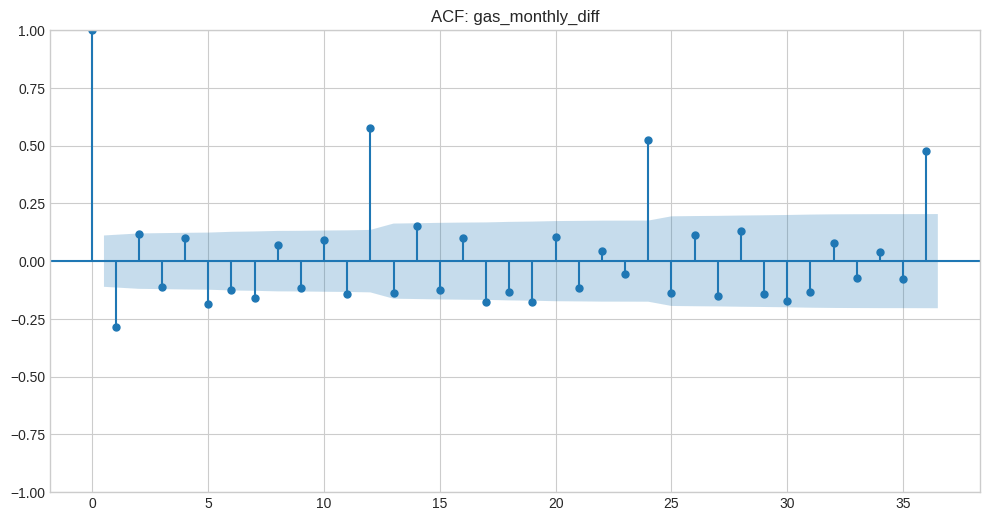

In [18]:
# Ваш код здесь
# Используйте plot_acf, передав в него ряд и ax
plt.figure(figsize=(10,4))
plot_acf(gas_monthly_diff, lags=36)
plt.title('ACF: gas_monthly_diff')
plt.show()

**Задание 16. Анализ частичной автокорреляции (PACF)**

Постройте график частичной автокорреляционной функции (PACF) для `gas_monthly_diff`. Это поможет определить порядок компоненты AR в модели ARIMA.

<Figure size 1000x400 with 0 Axes>

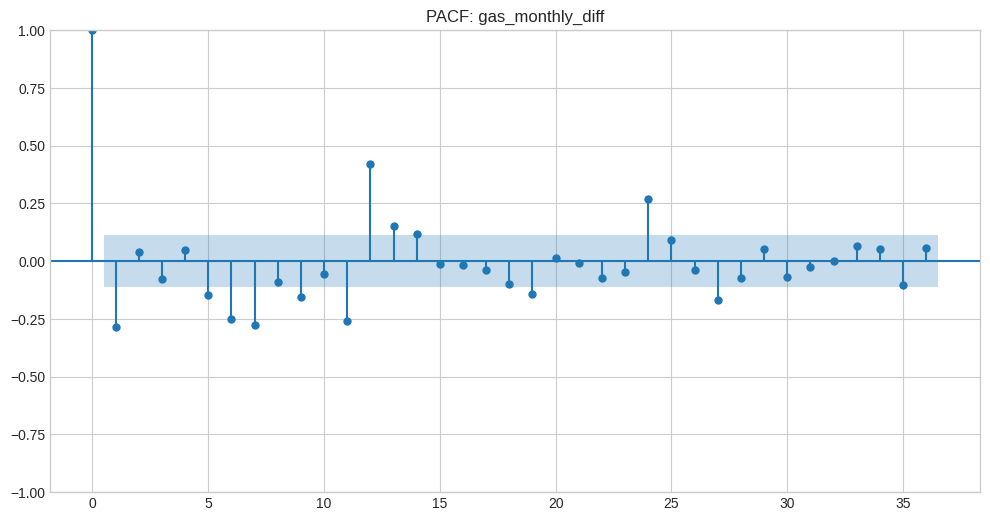

In [19]:
# Ваш код здесь
# Используйте plot_pacf, передав в него ряд и ax
plt.figure(figsize=(10,4))
plot_pacf(gas_monthly_diff, lags=36, method='ywm')
plt.title('PACF: gas_monthly_diff')
plt.show()

## Часть 4. Построение и оценка прогнозной модели ARIMA

Модель ARIMA (AutoRegressive Integrated Moving Average) — одна из самых популярных моделей для прогнозирования временных рядов.

- **AR (p):** Авторегрессионная часть, использующая зависимость от `p` предыдущих значений.
- **I (d):** Интегрированная часть, отвечающая за количество дифференцирований (`d`) для достижения стационарности.
- **MA (q):** Часть скользящего среднего, использующая зависимость от `q` предыдущих ошибок прогноза.

**Задание 17. Разделение данных на обучающую и тестовую выборки**

Разделите `gas_monthly['value']` на обучающую (все данные до 2015 года) и тестовую (данные с 2015 года) выборки. Это позволит нам оценить качество модели на данных, которые она не видела при обучении.

In [20]:
# Ваш код здесь
series = gas_monthly['value'].astype(float)

train_data = series.loc[:'2014-12'].dropna()
test_data  = series.loc['2015-01':].dropna()

display(pd.DataFrame({
    'train_start': [train_data.index.min()],
    'train_end':   [train_data.index.max()],
    'test_start':  [test_data.index.min()],
    'test_end':    [test_data.index.max()],
}))

,train_start,train_end,test_start,test_end
0,1991-02-28,2014-12-31,2015-01-31,2017-01-31


**Задание 18. Обучение модели ARIMA**

Обучите модель ARIMA на обучающей выборке (`train_data`). На основе графиков ACF/PACF и того, что мы применили одно дифференцирование, выберем порядок `(p, d, q) = (2, 1, 2)`. Выведите сводку по модели с помощью `.summary()`.

In [21]:
# Ваш код здесь
# 1. Создайте модель ARIMA
model = ARIMA(train_data, order=(2,1,2))
# 2. Обучите модель
model_fit = model.fit()
# 3. Выведите сводку
print(model_fit.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  287
Model:                 ARIMA(2, 1, 2)   Log Likelihood                  38.541
Date:                Mon, 08 Dec 2025   AIC                            -67.083
Time:                        17:12:21   BIC                            -48.803
Sample:                    02-28-1991   HQIC                           -59.756
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4038      0.086     -4.695      0.000      -0.572      -0.235
ar.L2          0.5961      0.086      6.952      0.000       0.428       0.764
ma.L1          0.1028      0.062      1.658      0.0

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


**Задание 19. Построение прогноза**

Сделайте прогноз на период, соответствующий тестовой выборке. Используйте `model_fit.predict()`, указав `start` и `end` индексы тестовой выборки.

In [22]:
# Ваш код здесь
start, end = test_data.index[0], test_data.index[-1]
pred = model_fit.predict(start=start, end=end, typ='levels')
pred.name = 'forecast'
display(pred.to_frame().head())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


,forecast
2015-01-31,9.115067
2015-02-28,9.127644
2015-03-31,8.995342
2015-04-30,9.056262
2015-05-31,8.952799


**Задание 20. Визуализация прогноза**

Постройте график, на котором будут отображены обучающие данные, реальные тестовые данные и ваш прогноз.

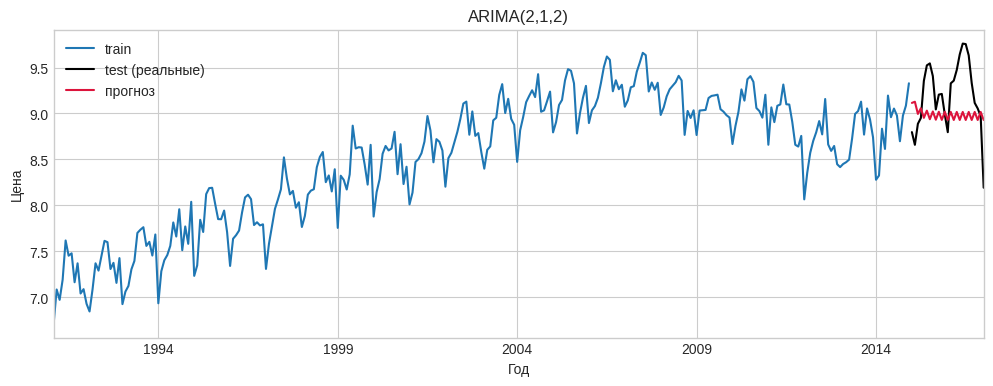

In [23]:
# Ваш код здесь
# Добавьте линию для прогноза
plt.figure(figsize=(12,4))
train_data.plot(label='train')
test_data.plot(label='test (реальные)', color='black')
pred.plot(label='прогноз', color='crimson')
plt.title('ARIMA(2,1,2)')
plt.xlabel('Год'); plt.ylabel('Цена'); plt.legend()
plt.show()

**Задание 21. Оценка качества модели**

Рассчитайте метрику RMSE (Root Mean Squared Error) для оценки точности вашего прогноза. RMSE = `sqrt(mean_squared_error(y_true, y_pred))`.

In [24]:
# Ваш код здесь
y_true = test_data.loc[pred.index].astype(float)
y_pred = pred.astype(float)

mse = mean_squared_error(y_true, y_pred)
rmse = (mse ** 0.5)
print(f'RMSE: {rmse:.3f}')

RMSE: 0.436


**Задание 22. Прогноз на будущее**

Теперь, когда модель оценена, используйте ее для прогнозирования на 12 месяцев вперед (за пределы имеющихся данных). Используйте метод `.forecast()`.

In [27]:
# Ваш код здесь
series = gas_monthly['value'].asfreq('M')
f = ARIMA(series, order=(2,1,2)).fit()
fc = f.forecast(12)

fc.index = pd.date_range(series.index[-1] + pd.offsets.MonthEnd(1), periods=12, freq='M')
fc.name = 'forecast_12m'

display(fc.head())

/tmp/ipython-input-3201976415.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  series = gas_monthly['value'].asfreq('M')
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipython-input-3201976415.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use

,forecast_12m
2017-02-28,8.549106
2017-03-31,8.633556
2017-04-30,8.830234
2017-05-31,8.812822
2017-06-30,8.944538


**Задание 23. Визуализация прогноза на будущее**

Постройте график, включающий все исторические данные (`gas_monthly['value']`) и прогноз на будущее.

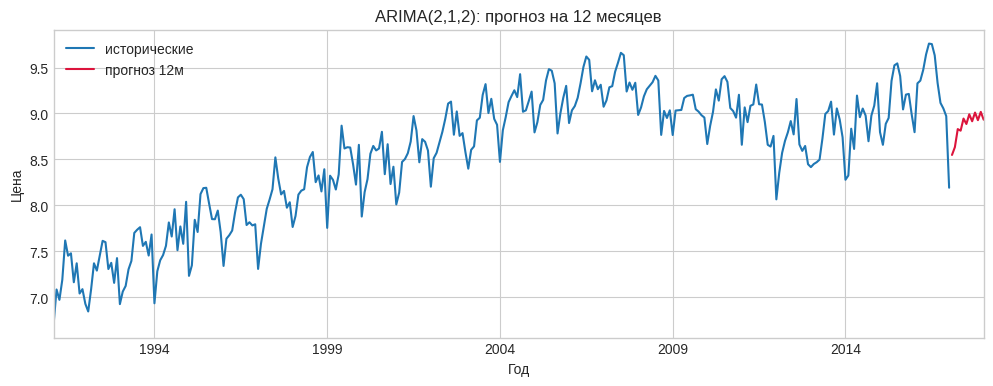

In [28]:
# Ваш код здесь
# Добавьте линию для прогноза на будущее
plt.figure(figsize=(12,4))
series.plot(label='исторические')
fc.plot(label='прогноз 12м', color='crimson')
plt.title('ARIMA(2,1,2): прогноз на 12 месяцев')
plt.xlabel('Год'); plt.ylabel('Цена'); plt.legend()
plt.show()

## Часть 5. Индивидуальные задания для самостоятельной работы

**Инструкция.** Выполните задания, соответствующие вашему варианту. В качестве основного набора данных используйте `gas_monthly` (ежемесячные данные о производстве бензина) или `unemployment_df` (квартальные данные об уровне безработицы), как указано в задании. Сначала загрузим второй датасет.

In [29]:
unemployment_url = "https://raw.githubusercontent.com/BosenkoTM/Python_for_scientists/refs/heads/main/data/US_unemployment.csv"
unemployment_df = pd.read_csv(unemployment_url, parse_dates=['date'], index_col='date')
print("Данные по безработице (head):")
print(unemployment_df.head())

print("\nДанные по производству бензина (head):")
print(gas_monthly.head())

Данные по безработице (head):
            value
date             
1959-03-31    5.8
1959-06-30    5.1
1959-09-30    5.3
1959-12-31    5.6
1960-03-31    5.2

Данные по производству бензина (head):
              value  rolling_mean_12
date                                
1991-02-28  6.71500              NaN
1991-03-31  7.08600              NaN
1991-04-30  6.97325              NaN
1991-05-31  7.19175              NaN
1991-06-30  7.61900              NaN


---
**Вариант 1:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных за период с 2005 по 2010 год.
3. **Преобразование:** Рассчитайте и нанесите на график скользящее среднее с окном 6 месяцев.
4. **Стационарность:** Примените дифференцирование первого порядка и проведите тест Дики-Фуллера.
5. **Прогноз:** Обучите модель ARIMA(1,1,1) на данных до 2014 года и сделайте прогноз на 12 шагов вперед.

---
**Вариант 2:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график всего временного ряда уровня безработицы.
3. **Декомпозиция:** Разложите ряд на тренд, сезонность и остаток.
4. **Корреляция:** Постройте график ACF для исходного ряда.
5. **Прогноз:** Обучите модель ARIMA(2,1,0) на данных до 2010 года и сделайте прогноз на 8 кварталов вперед.

---
**Вариант 3:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных за период с 1995 по 2000 год.
3. **Преобразование:** Рассчитайте и нанесите на график скользящее среднее с окном 24 месяца.
4. **Стационарность:** Постройте график PACF для дифференцированного ряда.
5. **Прогноз:** Обучите модель ARIMA(2,1,1) на данных до 2013 года и сделайте прогноз на 12 шагов.

---
**Вариант 4:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных с 2000 года до конца.
3. **Стационарность:** Примените дифференцирование и проверьте на стационарность с помощью теста ADF.
4. **Корреляция:** Постройте график PACF для дифференцированного ряда.
5. **Прогноз:** Обучите модель ARIMA(1,1,1) на данных до 2012 года, сделайте и визуализируйте прогноз на тестовом периоде (оставшиеся данные).

---
**Вариант 5:**
1. **Данные:** `gas_monthly`
2. **EDA:** Проведите декомпозицию ряда `gas_monthly`.
3. **Преобразование:** Агрегируйте данные до квартальной частоты (`'Q'`), используя медиану.
4. **Стационарность:** Проверьте агрегированный ряд на стационарность.
5. **Прогноз:** Обучите модель ARIMA(1,1,0) на `gas_monthly` (данные до 2012) и сделайте прогноз на 6 шагов.

---
**Вариант 6:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных за период с 1990 по 2000 год.
3. **Преобразование:** Рассчитайте скользящее среднее с окном в 4 квартала (1 год).
4. **Корреляция:** Постройте ACF и PACF для дифференцированного ряда.
5. **Прогноз:** Обучите модель ARIMA(2,1,2) на данных до 2005 года и сделайте прогноз на 10 кварталов.

---
**Вариант 7:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных за последние 5 лет (с 2012 года).
3. **Стационарность:** Примените дифференцирование второго порядка (`.diff().diff()`) и проверьте на стационарность.
4. **Корреляция:** Постройте ACF для ряда после двойного дифференцирования.
5. **Прогноз:** Обучите модель ARIMA(1,2,1) на данных до 2015 года и оцените её RMSE на оставшихся данных.

---
**Вариант 8:**
1. **Данные:** `unemployment_df`
2. **EDA:** Проведите декомпозицию ряда.
3. **Преобразование:** Рассчитайте скользящее среднее с окном в 8 кварталов (2 года).
4. **Стационарность:** Проведите тест ADF для исходного и дифференцированного рядов, сравните результаты.
5. **Прогноз:** Обучите модель ARIMA(0,1,1) на данных до 2008 года и сделайте прогноз на 12 кварталов.

---
**Вариант 9:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных, агрегированных до годовой частоты (`'A'`) по среднему значению.
3. **Декомпозиция:** Разложите исходный ежемесячный ряд на компоненты.
4. **Корреляция:** Постройте PACF для исходного ряда.
5. **Прогноз:** Обучите модель ARIMA(3,1,0) на данных до 2011 года и сделайте прогноз на 18 месяцев.

---
**Вариант 10:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных за период с 1970 по 1985 год.
3. **Преобразование:** Примените логарифмическое преобразование (`np.log`) к ряду и постройте его график.
4. **Стационарность:** Проверьте на стационарность логарифмированный ряд после одного дифференцирования.
5. **Прогноз:** Обучите модель ARIMA(1,1,2) на данных до 2000 года и сделайте прогноз на 15 кварталов.

---
**Вариант 11:**
1. **Данные:** `gas_monthly`
2. **EDA:** Рассчитайте и постройте график годового скользящего среднего (окно 12).
3. **Корреляция:** Постройте ACF и PACF для дифференцированного ряда.
4. **Моделирование:** Обучите модель ARIMA(1,1,1). Выведите `.summary()`.
5. **Оценка:** Разделите данные на train/test по 2013 году. Рассчитайте RMSE прогноза на тестовой выборке.

---
**Вариант 12:**
1. **Данные:** `unemployment_df`
2. **EDA:** Проведите декомпозицию. Проанализируйте график сезонной компоненты.
3. **Стационарность:** Проведите ADF тест на остатках (residuals) после декомпозиции.
4. **Корреляция:** Постройте ACF для остатков.
5. **Прогноз:** Обучите ARIMA(2,1,1) на данных до 2007 года и спрогнозируйте на 10 кварталов.

---
**Вариант 13:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных за период с 2010 года до конца.
3. **Преобразование:** Агрегируйте данные до 6-месячной частоты (`'6M'`) по сумме.
4. **Стационарность:** Проверьте стационарность агрегированного ряда.
5. **Прогноз:** Обучите ARIMA(0,1,2) на `gas_monthly` (данные до 2010) и сделайте прогноз на 24 месяца.

---
**Вариант 14:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график дифференцированного ряда.
3. **Корреляция:** Постройте PACF для дифференцированного ряда. Определите возможный порядок `p`.
4. **Моделирование:** Обучите модель ARIMA с порядком `p`, определённым на шаге 3, и `d=1`, `q=1`.
5. **Прогноз:** Сделайте прогноз на 6 кварталов вперед от конца имеющихся данных.

---
**Вариант 15:**
1. **Данные:** `gas_monthly`
2. **EDA:** Проведите декомпозицию. Выведите первые 5 значений трендовой и сезонной компонент.
3. **Преобразование:** Рассчитайте процентное изменение от месяца к месяцу (`.pct_change()`) и постройте график.
4. **Стационарность:** Проверьте на стационарность ряд процентных изменений.
5. **Прогноз:** Обучите ARIMA(2,1,2) на данных до 2011 года и сделайте прогноз на 12 шагов.

---
**Вариант 16:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график скользящего среднего с окном 2 (полгода).
3. **Корреляция:** Постройте ACF для дифференцированного ряда. Определите возможный порядок `q`.
4. **Моделирование:** Обучите модель ARIMA с порядком `q`, определённым на шаге 3, и `d=1`, `p=1`.
5. **Оценка:** Разделите данные по 2009 году. Рассчитайте RMSE модели на тестовой выборке.

---
**Вариант 17:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных за период с 2008 по 2012 год.
3. **Декомпозиция:** Проведите декомпозицию и постройте график только для сезонной компоненты.
4. **Стационарность:** Проведите тест ADF на сезонной компоненте.
5. **Прогноз:** Обучите ARIMA(1,1,3) на данных до 2010 года, спрогнозируйте на 12 шагов.

---
**Вариант 18:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных за период с 1995 по 2005 год.
3. **Преобразование:** Рассчитайте скользящее стандартное отклонение (`.rolling(4).std()`).
4. **Корреляция:** Постройте ACF и PACF для исходного (недифференцированного) ряда.
5. **Прогноз:** Обучите ARIMA(3,1,1) на данных до 2011 года, сделайте прогноз на 8 кварталов.

---
**Вариант 19:**
1. **Данные:** `gas_monthly`
2. **EDA:** Агрегируйте данные до годовой частоты по максимальному значению и постройте график.
3. **Корреляция:** Постройте ACF для ряда, дифференцированного дважды.
4. **Моделирование:** Обучите ARIMA(1,2,2) на данных до 2014 года.
5. **Прогноз:** Сделайте и визуализируйте прогноз на оставшихся данных (тестовый период).

---
**Вариант 20:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график исходных данных и наложите на него скользящее среднее с окном 10.
3. **Стационарность:** Проведите ADF тест на остатках (residuals) после декомпозиции.
4. **Моделирование:** Обучите модель ARIMA(2,1,3) на данных до 2006 года.
5. **Прогноз:** Сделайте прогноз на 12 кварталов вперед.

---
**Вариант 21:**
1. **Данные:** `gas_monthly`
2. **EDA:** Визуализируйте данные за 2000-2004 гг.
3. **Преобразование:** Рассчитайте скользящее среднее с окном 18 месяцев.
4. **Корреляция:** Постройте ACF и PACF для дифференцированного ряда.
5. **Прогноз:** Обучите ARIMA(2,1,0) на данных до 2013 года, спрогнозируйте на 15 месяцев.

---
**Вариант 22:**
1. **Данные:** `unemployment_df`
2. **EDA:** Проведите декомпозицию ряда.
3. **Стационарность:** Проведите тест ADF на трендовой компоненте.
4. **Моделирование:** Обучите модель ARIMA(0,1,2) на данных до 2011 года.
5. **Оценка:** Сделайте прогноз на тестовом периоде (остальные данные) и рассчитайте RMSE.

---
**Вариант 23:**
1. **Данные:** `gas_monthly`
2. **EDA:** Агрегируйте данные до квартальной частоты (`'Q'`) по максимальному значению и постройте график.
3. **Корреляция:** Постройте ACF для этого агрегированного ряда.
4. **Моделирование:** Обучите ARIMA(1,1,1) на агрегированном ряде (до 2014 года).
5. **Прогноз:** Сделайте прогноз на 4 квартала вперед.

---
**Вариант 24:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных с 1985 по 1995 год.
3. **Преобразование:** Рассчитайте скользящую медиану с окном 3 (`.rolling(3).median()`).
4. **Корреляция:** Постройте PACF для дифференцированного ряда.
5. **Прогноз:** Обучите ARIMA(2,1,1) на данных до 2004 года и сделайте прогноз на 8 кварталов.

---
**Вариант 25:**
1. **Данные:** `gas_monthly`
2. **EDA:** Визуализируйте остатки (residuals) после декомпозиции.
3. **Стационарность:** Проведите тест ADF на остатках.
4. **Моделирование:** Обучите модель ARIMA(3,1,2) на данных до 2012 года.
5. **Прогноз:** Сделайте прогноз на 10 месяцев вперед.

---
**Вариант 26:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных, агрегированных до годовой частоты (`'A'`) по среднему.
3. **Корреляция:** Постройте ACF для годового ряда.
4. **Моделирование:** Обучите ARIMA(1,1,0) на годовом ряде (до 2010 года).
5. **Прогноз:** Сделайте прогноз на 5 лет вперед.

---
**Вариант 27:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график скользящего среднего с окном 3 месяца.
3. **Корреляция:** Постройте ACF для ряда, дифференцированного дважды.
4. **Моделирование:** Обучите ARIMA(1,2,0) на данных до 2013 года.
5. **Оценка:** Рассчитайте RMSE модели на тестовом периоде (данные с 2013 года).

---
**Вариант 28:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных с 2005 года до конца.
3. **Декомпозиция:** Проведите декомпозицию и постройте график трендовой компоненты.
4. **Стационарность:** Проведите тест ADF для дифференцированного ряда.
5. **Прогноз:** Обучите ARIMA(1,1,3) на данных до 2009 года и сделайте прогноз на 8 кварталов.

---
**Вариант 29:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных за первые 10 лет (до 2001 года).
3. **Преобразование:** Рассчитайте логарифм ряда и примените к нему дифференцирование.
4. **Корреляция:** Постройте PACF для этого преобразованного ряда.
5. **Прогноз:** Обучите ARIMA(2,1,2) на исходных данных до 2010 года и сделайте прогноз на 12 шагов.

---
**Вариант 30:**
1. **Данные:** `unemployment_df`
2. **EDA:** Проведите декомпозицию ряда.
3. **Корреляция:** Постройте ACF и PACF для дифференцированного ряда.
4. **Моделирование:** Обучите ARIMA(2,1,2) на данных до 2012 года.
5. **Прогноз:** Визуализируйте прогноз на тестовом периоде и рассчитайте RMSE.

---
**Вариант 31:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график ряда, агрегированного до квартальной частоты по медиане.
3. **Стационарность:** Проведите тест ADF для этого квартального ряда.
4. **Моделирование:** Обучите ARIMA(1,1,1) на квартальном ряде (до 2012 года).
5. **Прогноз:** Сделайте прогноз на 6 кварталов вперед.

---
**Вариант 32:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график скользящего среднего с окном 5.
3. **Корреляция:** Постройте ACF для ряда, дифференцированного дважды.
4. **Моделирование:** Обучите ARIMA(1,2,1) на данных до 2007 года.
5. **Прогноз:** Сделайте прогноз на 10 кварталов.

---
**Вариант 33:**
1. **Данные:** `gas_monthly`
2. **EDA:** Декомпозируйте ряд. Постройте график остатков.
3. **Стационарность:** Проведите тест ADF на остатках.
4. **Моделирование:** Обучите ARIMA(2,1,3) на данных до 2015 года.
5. **Прогноз:** Сделайте прогноз на 12 месяцев вперед.

---
**Вариант 34:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных с 1999 по 2009 год.
3. **Преобразование:** Рассчитайте скользящее среднее с окном 6.
4. **Корреляция:** Постройте PACF для дифференцированного ряда.
5. **Прогноз:** Обучите ARIMA(3,1,0) на данных до 2010 года и спрогнозируйте на 8 кварталов.

---
**Вариант 35:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных за период с 1980 по 2000 год.
3. **Преобразование:** Рассчитайте скользящее среднее с окном в 4 квартала (1 год).
4. **Корреляция:** Постройте ACF и PACF для ряда, дифференцированного дважды (`.diff().diff()`).
5. **Прогноз:** Обучите модель ARIMA(2,2,2) на данных до 2008 года и спрогнозируйте следующие 10 кварталов.


# **Вариант 3**

In [30]:
#1 Данные: gas_monthly
display(gas_monthly)

,value,rolling_mean_12
date,,
1991-02-28,6.715000,NaN
1991-03-31,7.086000,NaN
1991-04-30,6.973250,NaN
1991-05-31,7.191750,NaN
1991-06-30,7.619000,NaN
...,...,...
2016-09-30,9.331500,9.373650
2016-10-31,9.115200,9.366146
2016-11-30,9.055000,9.352996


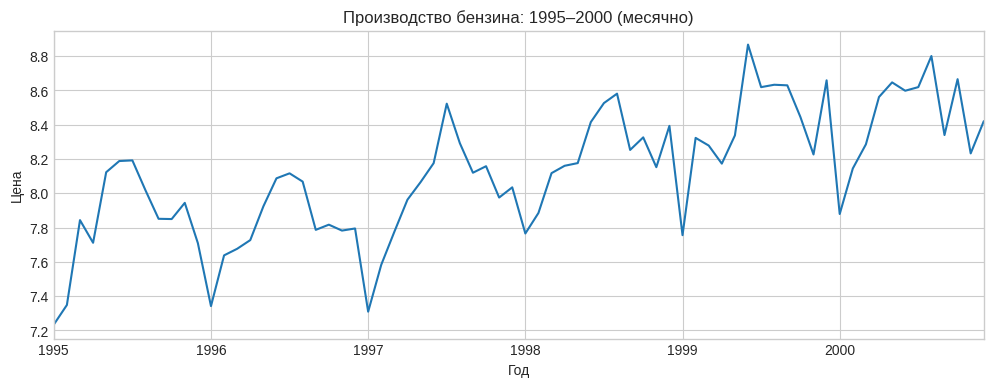

In [31]:
#2 EDA: Постройте график данных за период с 1995 по 2000 год.
ax = gas_monthly['value']['1995':'2000'].plot(figsize=(12,4))
ax.set_title('Производство бензина: 1995–2000 (месячно)')
ax.set_xlabel('Год'); ax.set_ylabel('Цена')
plt.show()

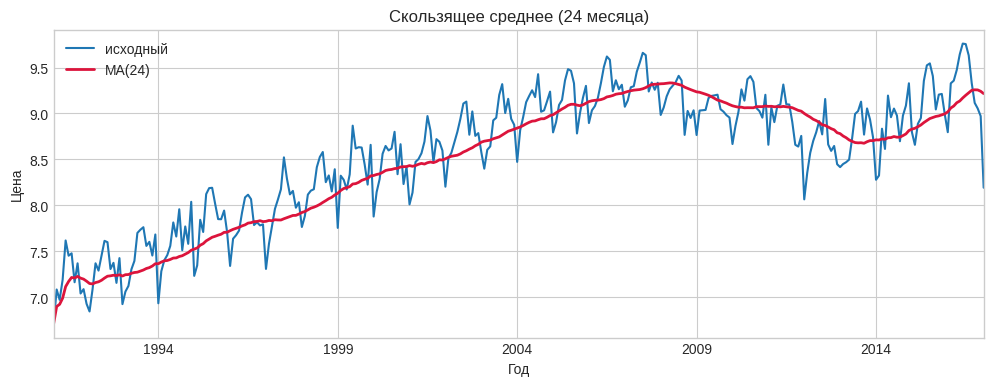

In [32]:
#3 Преобразование: Рассчитайте и нанесите на график скользящее среднее с окном 24 месяца.
ma24 = gas_monthly['value'].rolling(window=24, min_periods=1).mean()

plt.figure(figsize=(12,4))
gas_monthly['value'].plot(label='исходный')
ma24.plot(label='MA(24)', color='crimson', linewidth=2)
plt.title('Скользящее среднее (24 месяца)')
plt.xlabel('Год'); plt.ylabel('Цена'); plt.legend()
plt.show()

<Figure size 1000x400 with 0 Axes>

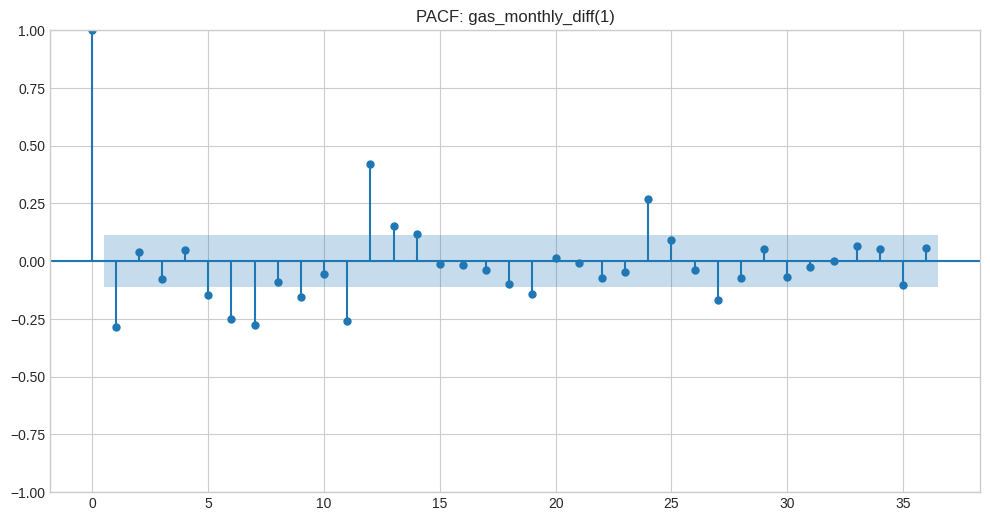

In [33]:
#4 Стационарность: Постройте график PACF для дифференцированного ряда.
gas_diff1 = gas_monthly['value'].diff().dropna()

plt.figure(figsize=(10,4))
plot_pacf(gas_diff1, lags=36, method='ywm')
plt.title('PACF: gas_monthly_diff(1)')
plt.show()

/tmp/ipython-input-2592331888.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_id = pd.date_range('2013-01-31', periods=12, freq='M')
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,forecast_2013
2013-01-31,8.410124
2013-02-28,8.495366
2013-03-31,8.400805
2013-04-30,8.497213
2013-05-31,8.400441
2013-06-30,8.497283
2013-07-31,8.400430
2013-08-31,8.497282
2013-09-30,8.400434
2013-10-31,8.497278


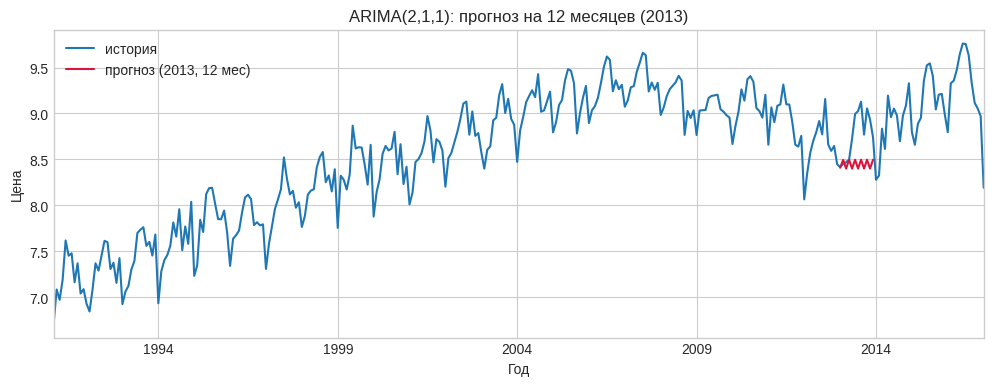

In [34]:
#5 Прогноз: Обучите модель ARIMA(2,1,1) на данных до 2013 года и сделайте прогноз на 12 шагов.
s = gas_monthly['value'].astype(float)

train = s.loc[:'2012-12'].dropna()
test_id = pd.date_range('2013-01-31', periods=12, freq='M')

model = ARIMA(train, order=(2,1,1))
fit = model.fit()

fc = fit.forecast(steps=12)
fc.index = test_id
fc.name = 'forecast_2013'

display(fc.to_frame())

plt.figure(figsize=(12,4))
s.plot(label='история')
fc.plot(label='прогноз (2013, 12 мес)', color='crimson')
plt.title('ARIMA(2,1,1): прогноз на 12 месяцев (2013)')
plt.xlabel('Год'); plt.ylabel('Цена'); plt.legend()
plt.show()